In [1]:
import numpy as np
from scipy.constants import c
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
import scipy.signal as signal
import scipy.stats as st
import itertools

In [2]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/np.max(kern2d)

In [3]:
def calculate_l2ref(lambda2, w):
    k = np.sum(w)
    return np.sum(w * lambda2) / k

In [4]:
def thinsource_simulation(lambda2, l2_ref, nu_0, spectral_idx, phi_gal, s_nu):
    nu = c / np.sqrt(lambda2)
    k = (nu / nu_0) ** (-1.0 * spectral_idx)
    mu_q = np.cos(2. * phi_gal * (lambda2 - l2_ref))
    mu_u = np.sin(2. * phi_gal * (lambda2 - l2_ref))

    # p = np.mean(np.sqrt(mu_q ** 2 + mu_u ** 2))

    return s_nu * k * (mu_q + 1j * mu_u)

In [5]:
def thicksource_simulation(lambda2, l2_ref, nu_0, spectral_idx, phi_fg, phi_center, s_nu):
    nu = c / np.sqrt(lambda2)
    k = (nu / nu_0) ** (-1.0 * spectral_idx)
    phi_fg = phi_fg / 2.
    j = 2. * (lambda2 - l2_ref) * (phi_center + phi_fg)
    k = 2. * (lambda2 - l2_ref) * (phi_center - phi_fg)
    mu_q = np.sin(j) - np.sin(k)
    const = s_nu * k / (2. * phi_fg * (lambda2 - l2_ref))
    mu_u = np.cos(j) - np.cos(k)

    return const * (mu_q + mu_u / 1j)

In [6]:
def remove_channels(lambda2=None, remove_frac=None, random_state=None, chunksize=None):

    remove_frac = 1.0 - remove_frac
    m = len(lambda2)
    if chunksize is None:
        chunksize = m // (10  + (10 * (1. - remove_frac)))

    _chansremoved = []
    while True:
        if random_state is None:
            pos = np.random.randint(0, m)  # get position
            width = np.random.uniform(0, chunksize)  # get chunk size
        else:
            pos = random_state.randint(0, m)  # get position
            width = random_state.uniform(0, chunksize)  # get chunk size
        low = int(pos - 0.5 * width)
        if low < 0:
            low = 0
        high = int(pos + 0.5 * width)
        if high >= m:
            high = m - 1

        _chansremoved.append(list(np.arange(low, high)))
        merged = list(itertools.chain(*_chansremoved))

        chans_removed = np.unique(np.ravel(np.array(merged)))
        frac = float(len(chans_removed)) / float(m)
        if frac > remove_frac:
            break

    # adjust back towards specified fraction
    # using single channel adjustments:
    while True:
        if random_state is None:
            idx = np.random.randint(0, len(chans_removed))
        else:
            idx = random_state.randint(0, len(chans_removed))
        chans_removed = np.delete(chans_removed, idx)
        frac = float(len(chans_removed)) / float(m)
        if frac <= remove_frac:
            break

    return chans_removed

In [7]:
np.random.seed(666)

In [8]:
antenna_diameter = 13.5 # meters
min_baseline = 29 # meters
max_baseline = 7700 # meters

In [9]:
# Image cube
m = 256
n = 256
nu_size = 1000
flux_peak = 0.01
noise = 0.1 * flux_peak
q_noise = np.random.normal(loc=0.0, scale=noise, size=(nu_size,m,n)).astype(np.float32)
u_noise = np.random.normal(loc=0.0, scale=noise, size=(nu_size,m,n)).astype(np.float32)
cube = q_noise + 1j * u_noise

In [10]:
nu_start=0.9e9
nu_end=1.67e9

In [11]:
oversampling_factor = 7
lambda_min = (c/nu_end)
pix_size = lambda_min/max_baseline/oversampling_factor
pix_size_arcsec = pix_size * (180.0 / np.pi) * 3600.0

In [12]:
print("The pixel size at L-band is ~{0:.2f} arcsec".format(pix_size_arcsec))

The pixel size at L-band is ~0.69 arcsec


In [13]:
nu = np.linspace(start=nu_start, stop=nu_end, num=nu_size, dtype=np.float32)
nu_0 = np.median(nu)

In [14]:
lambda_sq = (c/nu)**2
lambda_sq = lambda_sq[::-1]

In [15]:
sigma = noise * np.ones_like(lambda_sq).astype(np.float32)
weights = 1./sigma**2

In [16]:
l2_ref = calculate_l2ref(lambda_sq, weights)

In [17]:
n_random_pixels = 100
random_pixels = np.random.choice(m*n, size=n_random_pixels, replace=False).astype(np.int32)
random_pixels = np.unravel_index(random_pixels, (m,n))
random_source = np.random.randint(low=0, high=3, size=n_random_pixels, dtype=np.int32)
random_depolarized = np.random.randint(low=0, high=2, size=n_random_pixels, dtype=np.int32)

In [18]:
idx_thinsources = np.where(random_source == 0)[0]
idx_thicksources = np.where(random_source == 1)[0]
idx_mixsources = np.where(random_source==2)[0]
idx_depolarized = np.where(random_depolarized == 1)[0]

In [19]:
random_phi_center_thin = np.random.uniform(low=-200, high=200, size=len(idx_thinsources)).astype(np.float32)
random_phi_center_thick = np.random.uniform(low=-200, high=200, size=len(idx_thicksources)).astype(np.float32)
random_phi_center_mix = np.random.uniform(low=-200, high=200, size=(2, len(idx_mixsources))).astype(np.float32)
random_phi_width_thick = np.random.uniform(low=40, high=90, size=len(idx_thicksources)).astype(np.float32)
random_phi_width_mix = np.random.uniform(low=40, high=90, size=len(idx_mixsources)).astype(np.float32)
random_sigma_rm_depol = np.random.uniform(low=0, high=30, size=len(idx_depolarized)).astype(np.float32)

In [20]:
random_peak_thin = np.random.uniform(low=flux_peak*0.8, high=flux_peak, size=len(idx_thinsources)).astype(np.float32)
random_peak_thick = np.random.uniform(low=flux_peak*0.8, high=flux_peak, size=len(idx_thicksources)).astype(np.float32)
random_peak_mix = np.random.uniform(low=flux_peak*0.8, high=flux_peak, size=(2,len(idx_mixsources))).astype(np.float32)

In [21]:
x_idx_thin = random_pixels[0][idx_thinsources]
y_idx_thin = random_pixels[1][idx_thinsources]
cube[:, y_idx_thin, x_idx_thin] += thinsource_simulation(lambda_sq[:, np.newaxis], l2_ref, nu_0, 0.0, random_phi_center_thin, random_peak_thin)

In [22]:
x_idx_thick = random_pixels[0][idx_thicksources]
y_idx_thick = random_pixels[1][idx_thicksources]
cube[:, y_idx_thick, x_idx_thick] += thicksource_simulation(lambda_sq[:, np.newaxis], l2_ref, nu_0, 0.0, random_phi_width_thick, random_phi_center_thick, random_peak_thick)

In [23]:
x_idx_mix = random_pixels[0][idx_mixsources]
y_idx_mix = random_pixels[1][idx_mixsources]
cube[:, y_idx_mix, x_idx_mix] += thinsource_simulation(lambda_sq[:, np.newaxis], l2_ref, nu_0, 0.0, random_phi_center_mix[0], random_peak_mix[0]) + thicksource_simulation(lambda_sq[:, np.newaxis], l2_ref, nu_0, 0.0, random_phi_width_mix, random_phi_center_mix[1], random_peak_mix[1])

In [24]:
cube_before_depolarization = copy.deepcopy(cube)

In [25]:
x_idx_depolarized = random_pixels[0][idx_depolarized]
y_idx_depolarized = random_pixels[1][idx_depolarized]
cube[:, y_idx_depolarized, x_idx_depolarized] *= np.exp(-2. * random_sigma_rm_depol**2 * lambda_sq[:, np.newaxis]**2)

In [26]:
# Convolution with clean-beam
# Assumming bmaj == bmin for now
fwhm = 6.4 # arcseconds
bmaj = fwhm/np.sqrt(8*np.log(2.)) # arcseconds
bmaj_pix = bmaj / pix_size_arcsec
bmin_pix = bmaj_pix

In [27]:
bmaj_pix

3.9562310778877747

In [28]:
gkernel = gkern(11, bmaj_pix)

In [29]:
gkernel.shape

(11, 11)

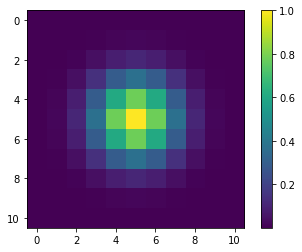

In [30]:
plt.imshow(gkernel)
plt.colorbar()

In [31]:
np.max(gkernel)

1.0

In [32]:
cube = signal.convolve(cube, gkernel[np.newaxis, :, :], mode="same")
cube_before_depolarization = signal.convolve(cube_before_depolarization, gkernel[np.newaxis, :, :], mode="same")

In [33]:
remove_frac = 0.3
final_idxs = remove_channels(lambda2=lambda_sq, remove_frac=remove_frac, random_state=None, chunksize=None)

In [34]:
cube = cube[final_idxs]
cube_before_depolarization = cube_before_depolarization[final_idxs]
lambda_sq = lambda_sq[final_idxs]

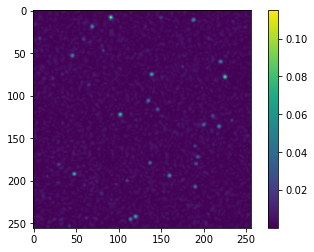

In [35]:
plt.imshow(np.abs(cube[5].real))
plt.colorbar()

In [36]:
print(y_idx_thin)

[142 233  10 212 123  61  32  90 222  94 129 144  40 109  84  41 168 229
  71  89 218  77  74  33 147  25  75]


In [37]:
print(x_idx_thin)

[ 24  69 156  68  73 236 119 119 191 182 150  34 213 164 210 156 222 187
   9 236 116 241 212 126 252  78  34]


In [38]:
print(y_idx_thick)

[103  11 199 207  87 136  10 180  42  75 192  78 122 245  12 204  53  56
 116  26  55 194  52 244  47 214  52  86 167 159 205 116  33 128]


In [39]:
print(x_idx_thick)

[ 26 188 175 190  65 218  49 191 163 139 125 225  93 158 234  97  46 115
 146 115   3 160  73  62  82  80  85  85  90 190  60 142   7 122]


In [49]:
print(x_idx_mix)

[150 102 126 233 230 135 191  91 113  23 193 200  30 220 175 165 211  18
  59  42 112 247  16  18 211  99  24 195 137 178 114  46  30  48  69 110
 199 109 120]


In [50]:
print(y_idx_mix)

[  8 122  51 129 138 106 105   8 195  80 172 134 181  60  66   6 124 166
  34 253  45 151 195 248 158  29  77  13 179 118 245 117 154 192  19 200
 139 167 242]


In [40]:
x_idx_depolarized

array([ 24,  26, 233, 230, 156, 175, 190, 191, 236, 113,  49,  23, 193,
       119, 139, 150, 200, 125, 158,  97, 164, 165, 156, 211, 115,   3,
       222, 187,  59,   9, 247,  73,  16,  62, 116,  82, 126,  99, 137,
       190,  30,  48,   7, 199, 109,  78, 120])

In [41]:
y_idx_depolarized

array([142, 103, 129, 138,  10, 199, 207, 105,  61, 195,  10,  80, 172,
        90,  75, 129, 134, 192, 245, 204, 109,   6,  41, 124,  26,  55,
       168, 229,  34,  71, 151,  52, 195, 244, 218,  47,  33,  29, 179,
       159, 154, 192,  33, 139, 167,  25, 242])

In [42]:
random_sigma_rm_depol

array([26.681015  , 26.741003  , 21.609388  , 22.898264  ,  1.3726676 ,
       25.222868  ,  7.131686  , 28.791878  , 11.849089  , 24.830963  ,
       27.432995  ,  1.576371  , 19.422611  , 21.794407  ,  7.698731  ,
        9.974227  ,  0.1537907 , 16.26625   , 22.504898  , 12.768759  ,
       11.848907  , 18.143623  ,  6.6683455 , 13.712088  , 22.326824  ,
       22.605562  , 26.512144  ,  2.650123  ,  6.3475313 ,  4.062576  ,
       26.945267  , 23.758457  , 21.317373  ,  9.421618  , 21.073895  ,
        7.040702  , 23.986229  , 11.567172  ,  0.34632427, 17.860058  ,
       24.586576  , 11.745337  ,  0.56204706,  7.24374   , 16.343443  ,
       25.035666  ,  5.183109  ], dtype=float32)

In [43]:
x_idx_test = 120
y_idx_test = 242

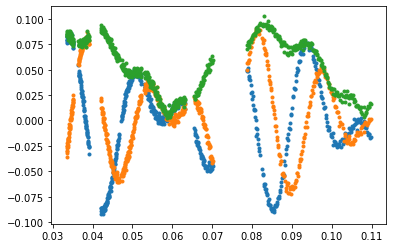

In [44]:
plt.plot(lambda_sq, cube_before_depolarization[:, y_idx_test, x_idx_test].real, '.')
plt.plot(lambda_sq, cube_before_depolarization[:, y_idx_test, x_idx_test].imag, '.')
plt.plot(lambda_sq, np.abs(cube_before_depolarization[:, y_idx_test, x_idx_test]), '.')

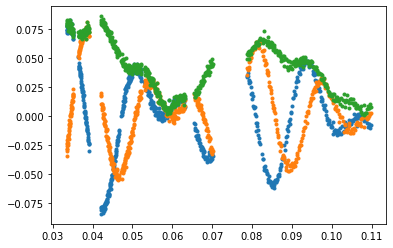

In [45]:
plt.plot(lambda_sq, cube[:, y_idx_test, x_idx_test].real, '.')
plt.plot(lambda_sq, cube[:, y_idx_test, x_idx_test].imag, '.')
plt.plot(lambda_sq, np.abs(cube[:, y_idx_test, x_idx_test]), '.')

In [46]:
output_cube = np.concatenate((cube.real[:,None],cube.imag[:,None]),axis=1)

In [47]:
fits.writeto("test.fits", output_cube, overwrite=True)